### Постановка задачи

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


Импортируем библиотеки и считываем тренировочный набор данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from catboost import CatBoostClassifier
%matplotlib inline

In [2]:
train = pd.read_csv("./CW/course_project_train.csv")
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Анализ и предобработка данных
#### Анализ
Проанализируем набор данных

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [4]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Сохраним имя столбца телевого показателя.

In [5]:
TARGET = 'Credit Default'

Построим матрицу корреляции

<Axes: >

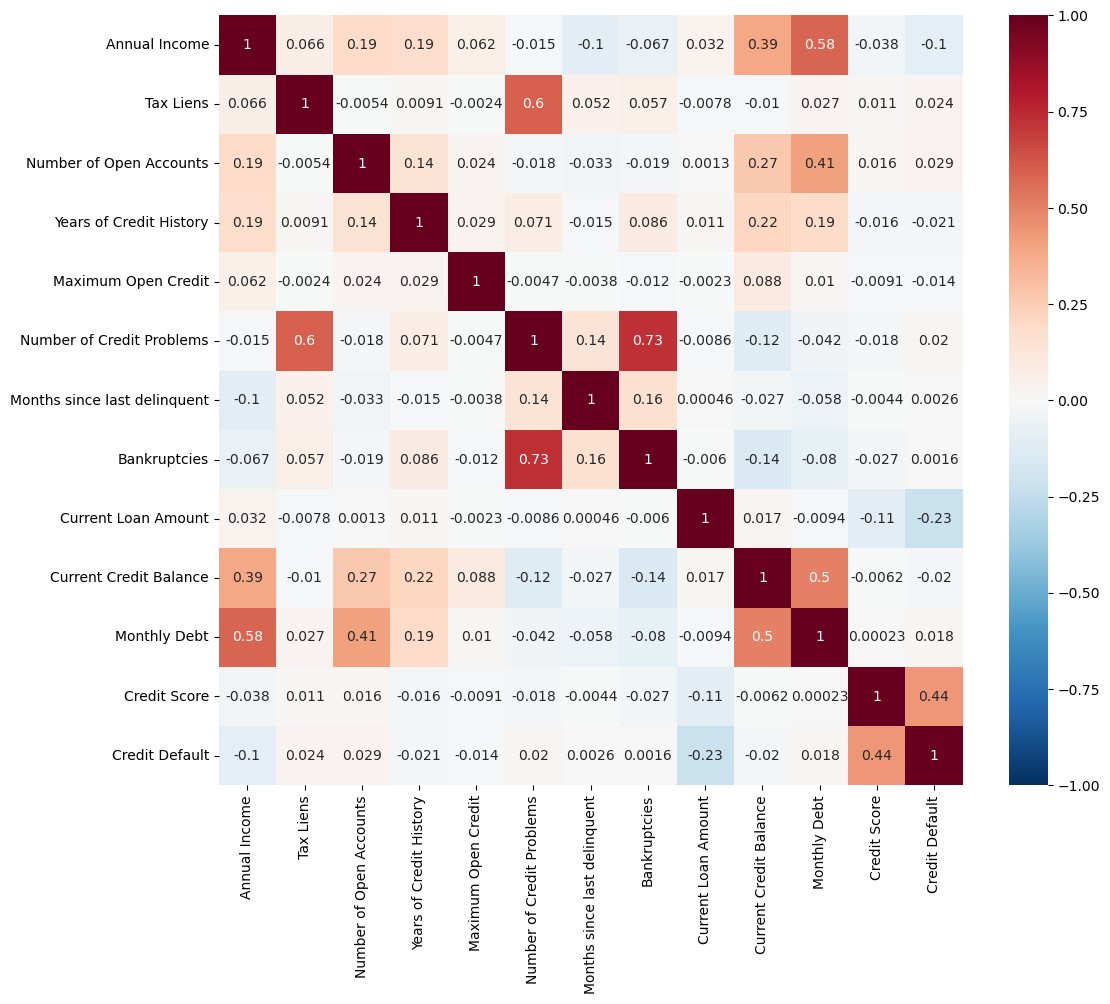

In [6]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(), cmap='RdBu_r', annot=True, vmin=-1, vmax=1)

Наблюдаем заметную корреляцию между целевой переменной и кредитным рейтингом, а так же ряд других корреляций, как например корреляция между количеством банкротств и количеством проблемных кредитов или между годовым доходом и долгом за месяц (выше доход - больший кредит можно получить).

### Предобработка данных
Проведём предварительную обработку данных.

##### Home Ownership 
Категориальный показатель наличия недвижимости.

In [7]:
train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

<Axes: xlabel='Home Ownership', ylabel='Credit Default'>

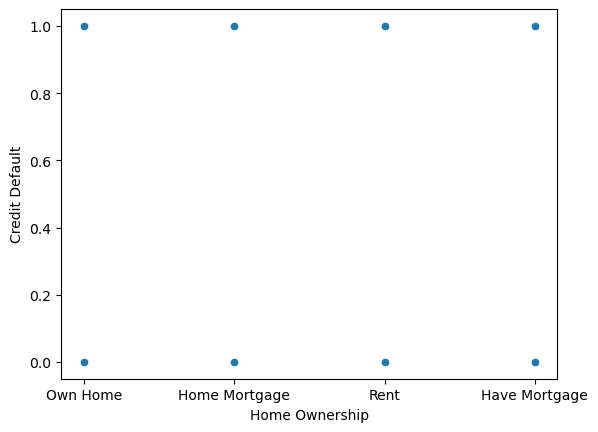

In [8]:
sns.scatterplot(data=train, x='Home Ownership', y=TARGET)

##### Annual Income
Годовой доход

<Axes: xlabel='Annual Income', ylabel='Count'>

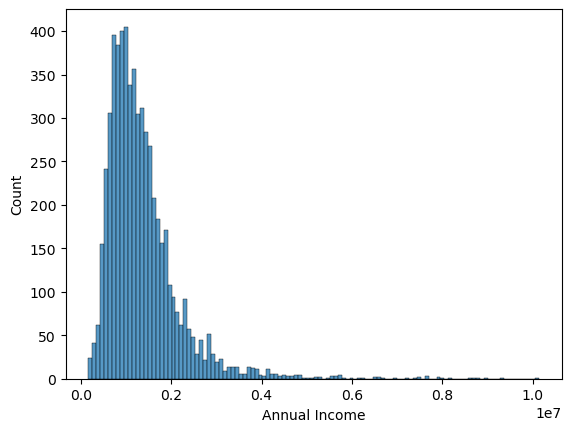

In [9]:
sns.histplot(train["Annual Income"])

<Axes: xlabel='Annual Income'>

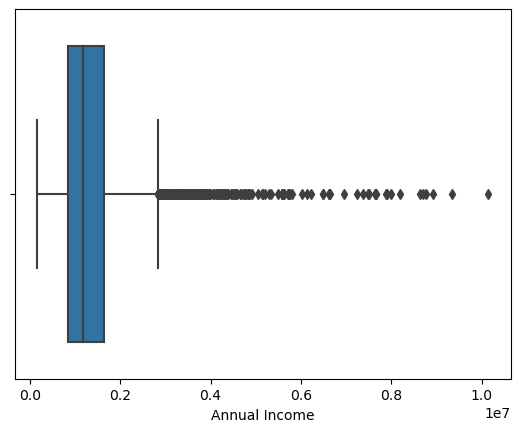

In [10]:
sns.boxplot(data=train, x="Annual Income")

Статистические выбросы в данном случае - это наиболее обеспеченные клиенты банка.

##### Years in current job
Стаж на текущей работе - является категориальным признаком.

In [11]:
train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

### Tax Liens
Налоговые обременения.

<Axes: xlabel='Tax Liens', ylabel='Count'>

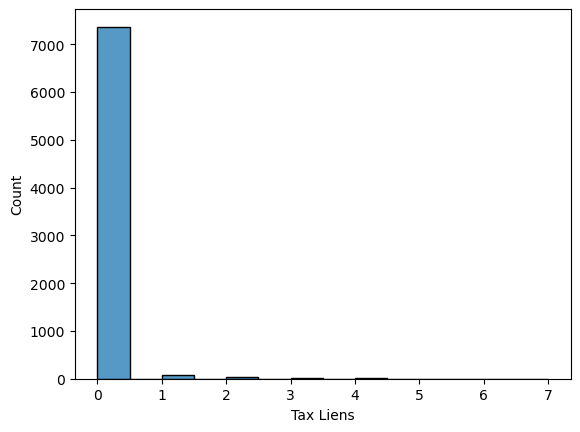

In [12]:
sns.histplot(train["Tax Liens"])

##### Number of Open Accounts
Количество открытых счетов

<Axes: xlabel='Number of Open Accounts', ylabel='Count'>

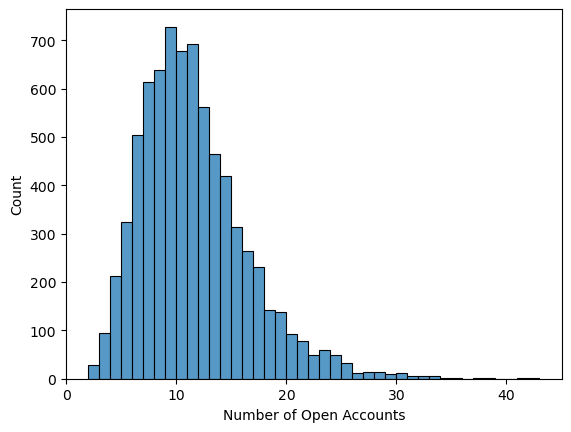

In [13]:
sns.histplot(train["Number of Open Accounts"], binwidth=1)

##### Years of Credit History
Количество лет кредитной истории

<Axes: xlabel='Years of Credit History', ylabel='Count'>

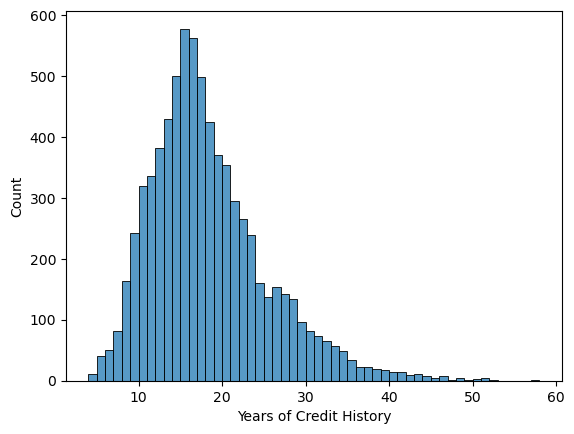

In [14]:
sns.histplot(train["Years of Credit History"], binwidth=1)

##### Maximum Open Credit
Наибольший открытый кредит

<Axes: xlabel='Maximum Open Credit'>

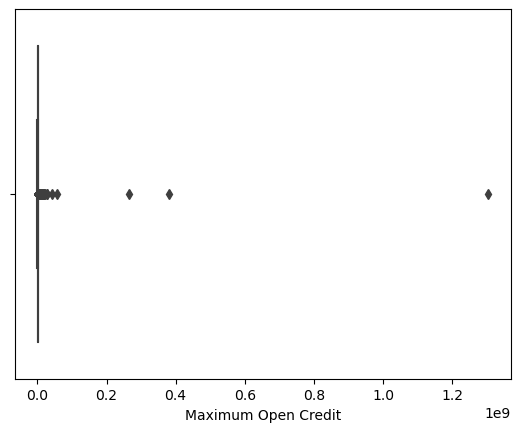

In [15]:
sns.boxplot(data=train, x="Maximum Open Credit")

<Axes: xlabel='Maximum Open Credit', ylabel='Credit Default'>

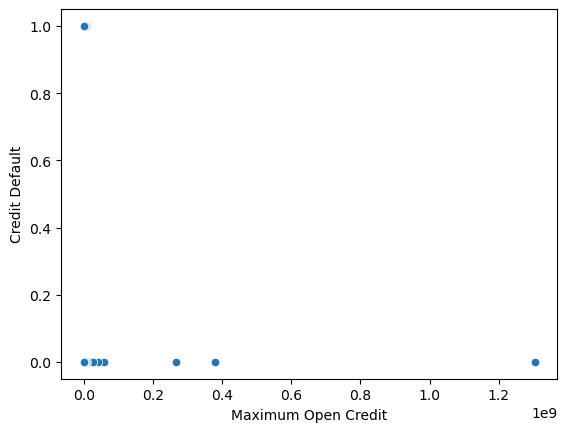

In [16]:
sns.scatterplot(data=train, x='Maximum Open Credit', y=TARGET)

##### Number of Credit Problems
Количество проблем с кредитом

In [17]:
train["Number of Credit Problems"].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

<Axes: xlabel='Number of Credit Problems', ylabel='Credit Default'>

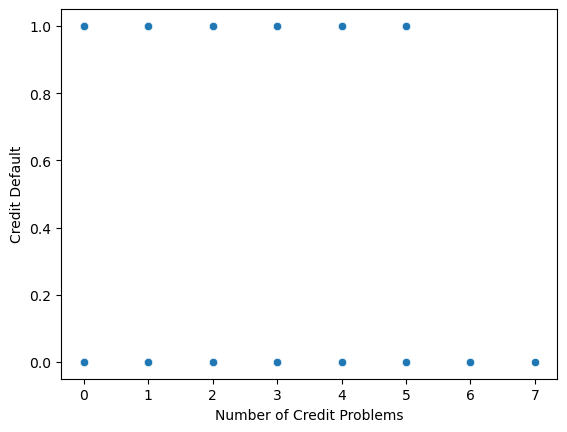

In [18]:
sns.scatterplot(data=train, x='Number of Credit Problems', y=TARGET)

##### Months since last delinquent
Количество месяцев с последней просрочки платежа. Для больше чем половины объектов - нет данных. Примем факт отсутствия данных для этого параметра как показатель отсутствия просрочек в прошлом.

<Axes: xlabel='Months since last delinquent', ylabel='Count'>

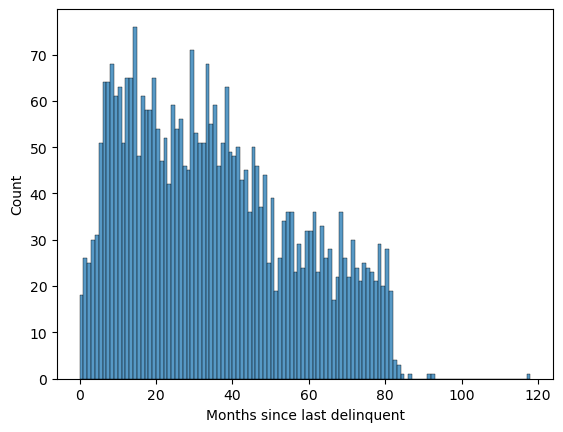

In [19]:
sns.histplot(train["Months since last delinquent"], binwidth=1)

In [20]:
train['Months since last delinquent'].isna().sum()

4081

<Axes: xlabel='Months since last delinquent'>

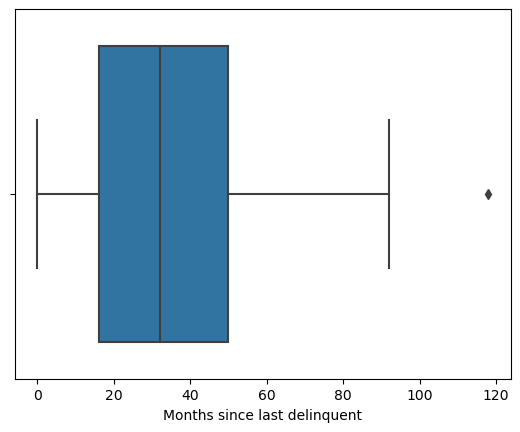

In [21]:
sns.boxplot(data=train, x="Months since last delinquent")

##### Bankruptcies
Банкротства

In [22]:
train["Bankruptcies"].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

##### Purpose
Цель кредита

In [23]:
train["Purpose"].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

<Axes: xlabel='Credit Default', ylabel='Purpose'>

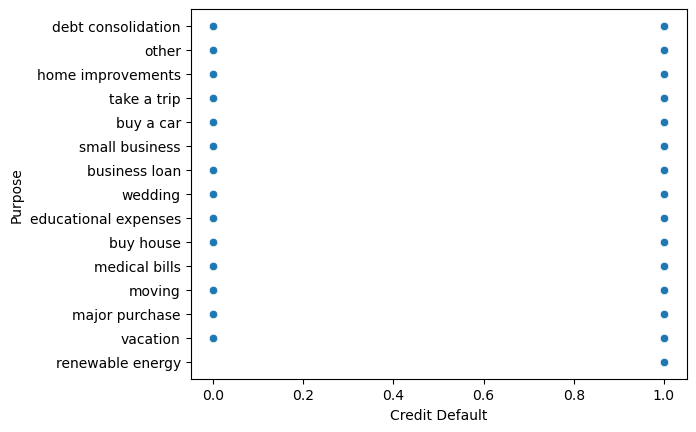

In [24]:
sns.scatterplot(data=train, y='Purpose', x=TARGET)

##### Term
Срок кредита

In [25]:
train["Term"].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

##### Current Loan Amount
Текущая сумма кредита

<Axes: xlabel='Current Loan Amount', ylabel='Count'>

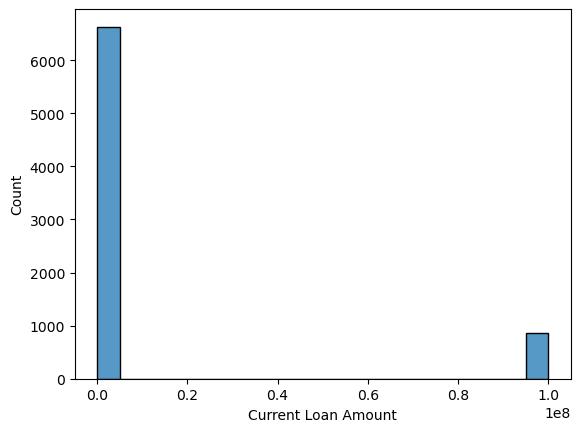

In [26]:
sns.histplot(train["Current Loan Amount"], bins=20)

<Axes: xlabel='Current Loan Amount', ylabel='Credit Default'>

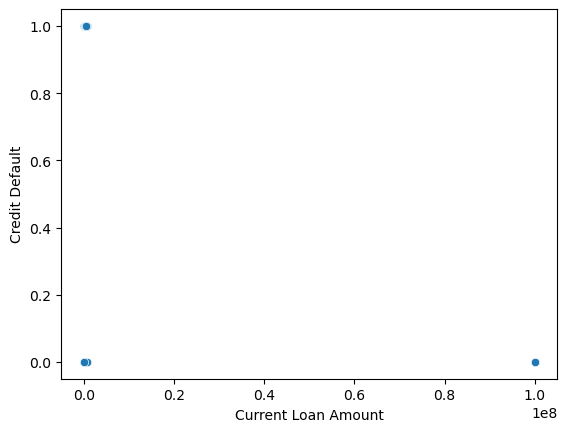

In [27]:
sns.scatterplot(data=train, x='Current Loan Amount', y=TARGET)

In [28]:
train.sort_values(by='Current Loan Amount', ascending=False).head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
4471,Own Home,651833.0,3 years,0.0,7.0,13.5,418638.0,0.0,NaN,0.0,home improvements,Short Term,99999999.0,97983.0,13145.0,740.0,0
6646,Rent,912000.0,2 years,0.0,21.0,19.4,1663046.0,0.0,NaN,0.0,other,Long Term,99999999.0,113468.0,18620.0,744.0,0
4384,Home Mortgage,2802671.0,8 years,0.0,30.0,36.1,1297802.0,0.0,21.0,0.0,educational expenses,Short Term,99999999.0,574997.0,46711.0,646.0,0
4388,Rent,2103376.0,8 years,0.0,8.0,17.5,949410.0,0.0,53.0,0.0,debt consolidation,Short Term,99999999.0,586264.0,19456.0,734.0,0


In [29]:
(train["Current Loan Amount"] == 99999999).sum()

870

Как видим - имеется ошибка ввода данных. Заменим все значения 99999999 на NaN. При этом значение 99999999 однозначно определяет принадлежность к классу 0 - выделим это в отдельный признак.

In [30]:
train["High CLA"] = 0
train.loc[train["Current Loan Amount"] == 99999999, "High CLA"] = 1
train.loc[train["Current Loan Amount"] == 99999999, "Current Loan Amount"] = np.nan

<Axes: xlabel='Current Loan Amount', ylabel='Count'>

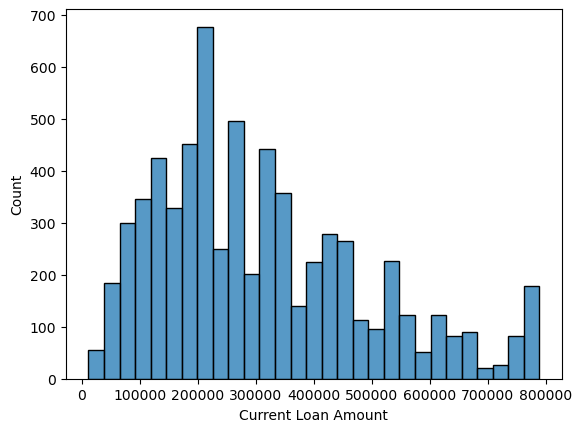

In [31]:
sns.histplot(train["Current Loan Amount"])

##### Current Credit Balance
Текущий кредитный баланс

<Axes: xlabel='Current Credit Balance', ylabel='Count'>

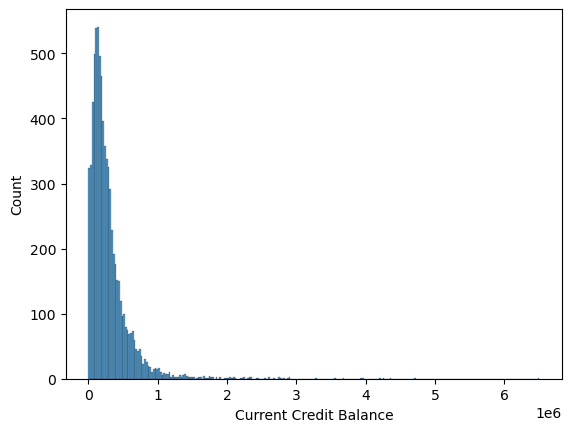

In [32]:
sns.histplot(train["Current Credit Balance"])

##### Monthly Debt
Ежемесячный долг

<Axes: xlabel='Monthly Debt', ylabel='Count'>

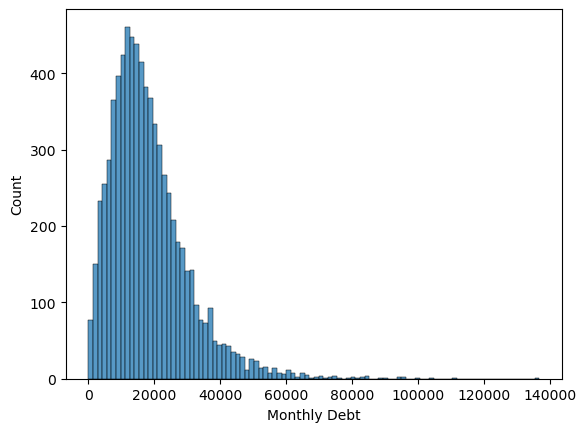

In [33]:
sns.histplot(train["Monthly Debt"])

##### Credit Score
Кредитный рейтинг

<Axes: xlabel='Credit Score', ylabel='Count'>

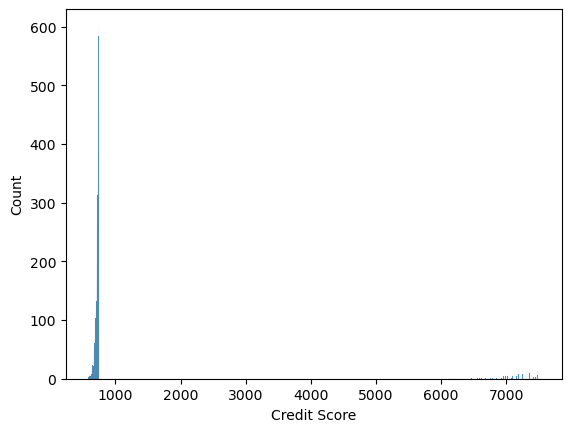

In [34]:
sns.histplot(train["Credit Score"])

<Axes: xlabel='Credit Score', ylabel='Credit Default'>

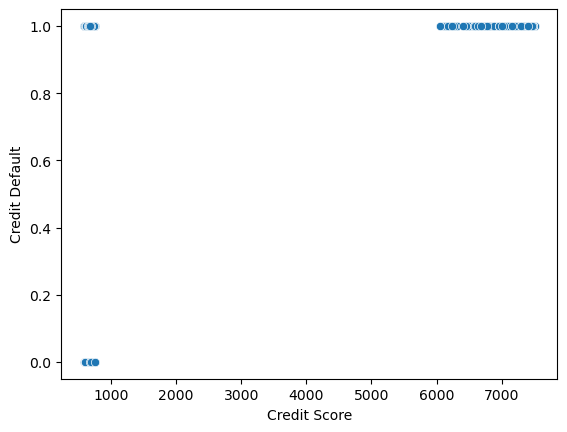

In [35]:
sns.scatterplot(data=train, x='Credit Score', y=TARGET)

In [36]:
(train["Credit Score"] > 1000).sum()

400

Предполагаем, что кредитный рейтинг принимает значения до 1000, и все значения больше чем 1000 это ошибка ввода - введен лишний 0 в конце $\Rightarrow$ делим значение на 10. Но при этом значение выше 1000 однозначно определяет принадлежность к классу 1 $\Rightarrow$ создадим отдельный параметр 'High Score'.

In [37]:
train['High Score'] = 0
train.loc[train["Credit Score"] >= 1000, "High Score"] = 1
train.loc[train["Credit Score"] >= 1000, "Credit Score"] /= 10

<Axes: xlabel='Credit Score', ylabel='Count'>

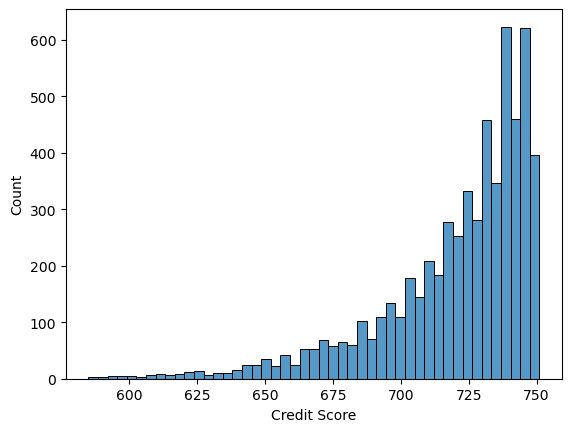

In [38]:
sns.histplot(train["Credit Score"])

##### Credit Default
Факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка). Целевая переменная.

In [39]:
train["Credit Default"].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Как видим - размеры классов отличаются почти в три раза $\Rightarrow$ учтем дисбаланс классов в построении модели через введение весов классов.

### Подготовка данных для обработки

Составим список категориальных параметров. Отнесем к категориальным в том числе и параметры, представленные целыми числами (кол-во банкротств, стаж на текущей работе в годах и т.д.). Все прочие параметры внесем в список числовых параметров.

In [40]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
                     'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
                     'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term','High CLA', 'High Score']
NUM_FEATURE_NAMES = [name for name in train.drop(TARGET, axis=1).columns if name not in CAT_FEATURE_NAMES]

Поскольку для заполнения отсутствующих значений будет использоваться IterativeImputer, Приобразуем все строковые категориальные параметры в числовые. Для этого параметр рабочего стажа считаем путем поиска числового значения в строке, а для остальных - присвоением значениям номеров по порядку.

In [41]:
years_dict = {year:int(0) if year.split()[0] == '<' else int(year.split()[0][:2]) for year in train['Years in current job'].value_counts().keys()}
years_dict

{'10+ years': 10,
 '2 years': 2,
 '3 years': 3,
 '< 1 year': 0,
 '5 years': 5,
 '1 year': 1,
 '4 years': 4,
 '6 years': 6,
 '7 years': 7,
 '8 years': 8,
 '9 years': 9}

In [42]:
cat_dict = {col:{k: i for i, k in enumerate(train[col].unique())} for col in train.select_dtypes(object).columns if col != 'Years in current job'}
cat_dict

{'Home Ownership': {'Own Home': 0,
  'Home Mortgage': 1,
  'Rent': 2,
  'Have Mortgage': 3},
 'Purpose': {'debt consolidation': 0,
  'other': 1,
  'home improvements': 2,
  'take a trip': 3,
  'buy a car': 4,
  'small business': 5,
  'business loan': 6,
  'wedding': 7,
  'educational expenses': 8,
  'buy house': 9,
  'medical bills': 10,
  'moving': 11,
  'major purchase': 12,
  'vacation': 13,
  'renewable energy': 14},
 'Term': {'Short Term': 0, 'Long Term': 1}}

Вставим вместо строковых параметров соответствующие им числовые.

In [43]:
train.replace({'Years in current job':years_dict}, inplace=True)
train.replace(cat_dict, inplace=True)

### Вставка пропущенных значений
Заполним пропущенные значения при помощи IterateImputer. Поскольку IterateImputer работает только с float, а CatBoost для категориальных параметров допускает только string либо integer, то преобразуем все категориальные параметры к типу int.

In [44]:
imp = IterativeImputer(random_state=42)
imp.fit(train.drop(TARGET, axis=1))

IterativeImputer(random_state=42)

In [45]:
y = train[TARGET]
train = pd.DataFrame(imp.transform(train.drop(TARGET, axis=1)), columns=train.drop(TARGET, axis=1).columns)
train[TARGET] = y
train[CAT_FEATURE_NAMES] = train[CAT_FEATURE_NAMES].astype(int)

In [46]:
train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,High CLA,High Score,Credit Default
0,0,4.820870e+05,7,0,11,26,685960,1,40,1,0,0,193884.171573,47386.0,7914.0,749.000000,1,0,0
1,0,1.025487e+06,10,0,15,15,1181730,0,33,0,0,1,264968.000000,394972.0,18373.0,737.000000,0,0,1
2,1,7.514120e+05,8,0,11,35,1182434,0,34,0,0,0,251576.778392,308389.0,13651.0,742.000000,1,0,0
3,0,8.050680e+05,6,0,8,22,147400,1,40,1,0,0,121396.000000,95855.0,11338.0,694.000000,0,0,0
4,2,7.762640e+05,8,0,13,13,385836,1,38,0,0,0,125840.000000,93309.0,7180.0,719.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,2,4.021920e+05,0,0,3,8,107866,0,37,0,1,0,129360.000000,73492.0,1900.0,697.000000,0,0,0
7496,1,1.533984e+06,1,0,10,26,686312,0,43,0,0,1,444048.000000,456399.0,12783.0,741.000000,0,1,1
7497,2,1.878910e+06,6,0,12,32,1778920,0,32,0,4,0,356557.981603,477812.0,12479.0,748.000000,1,0,0
7498,1,2.366004e+06,7,0,21,26,1141250,0,30,0,0,0,615274.000000,476064.0,37118.0,728.218955,0,0,0


Создадим функцию подготовки данных, чтобы с её помощью обработать тестовые данные. В ней пропишем все выше проведенные преобразования.

### Отделение валидационных данных

In [47]:
train, valid = train_test_split(train, test_size=0.2, random_state=42)
X_valid, y_valid = valid.drop(TARGET, axis=1), valid[TARGET]
X_train, y_train = train.drop(TARGET, axis=1), train[TARGET]

In [48]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 970 to 2669
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                1500 non-null   int64  
 1   Annual Income                 1500 non-null   float64
 2   Years in current job          1500 non-null   int64  
 3   Tax Liens                     1500 non-null   int64  
 4   Number of Open Accounts       1500 non-null   int64  
 5   Years of Credit History       1500 non-null   int64  
 6   Maximum Open Credit           1500 non-null   int64  
 7   Number of Credit Problems     1500 non-null   int64  
 8   Months since last delinquent  1500 non-null   int64  
 9   Bankruptcies                  1500 non-null   int64  
 10  Purpose                       1500 non-null   int64  
 11  Term                          1500 non-null   int64  
 12  Current Loan Amount           1500 non-null   float64
 13  C

Валидационные данные приведены в соответствие с обучающими

### Создание функций подготовки данных и создания отчета о метриках

In [49]:
def prepare_data(df):
    df["High CLA"] = 0
    df.loc[df["Current Loan Amount"] == 99999999, "High CLA"] = 1
    df.loc[df["Current Loan Amount"] == 99999999, "Current Loan Amount"] = np.nan
    df['High Score'] = 0
    df.loc[df["Credit Score"] >= 1000, "High Score"] = 1
    df.loc[df["Credit Score"] >= 1000, "Credit Score"] /= 10
    df.replace({'Years in current job':years_dict}, inplace=True)
    df.replace(cat_dict, inplace=True)
    df = pd.DataFrame(imp.transform(df), columns=df.columns)
    df[CAT_FEATURE_NAMES] = df[CAT_FEATURE_NAMES].astype(int)
    return df;

In [50]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### Обучение модели
Импортируем модель CatBoostClassifier, создаем экземпляр модели и обучаем её. Укажем вес классов, остальные параметры возьмем по умолчанию.

In [51]:
model = CatBoostClassifier(verbose=False, class_weights=[1, 2.3], eval_metric='F1', random_state=42, cat_features=CAT_FEATURE_NAMES)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      4328
           1       0.67      0.74      0.70      1672

    accuracy                           0.83      6000
   macro avg       0.78      0.80      0.79      6000
weighted avg       0.83      0.83      0.83      6000

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1059
           1       0.54      0.54      0.54       441

    accuracy                           0.73      1500
   macro avg       0.67      0.67      0.67      1500
weighted avg       0.73      0.73      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               853  206
1               203  238


Для валидационных данных имеем значение F1 = 0.54 при значениях "достоверности" (precision) и "полноты" (recall) выше 0.5. Следовательно требования к курсовой выполнены.

Как показал дальнейший подбор оптимальных параметров через случайный поиск, применение "оптимальных" параметров не приводит к сколь-нибудь значимому улучшению метрики F1 $\Rightarrow$ оставим параметры модели на значении по умолчанию.

### Оценка важности параметров

In [52]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(data=feature_importances, x='importance', y='feature')
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

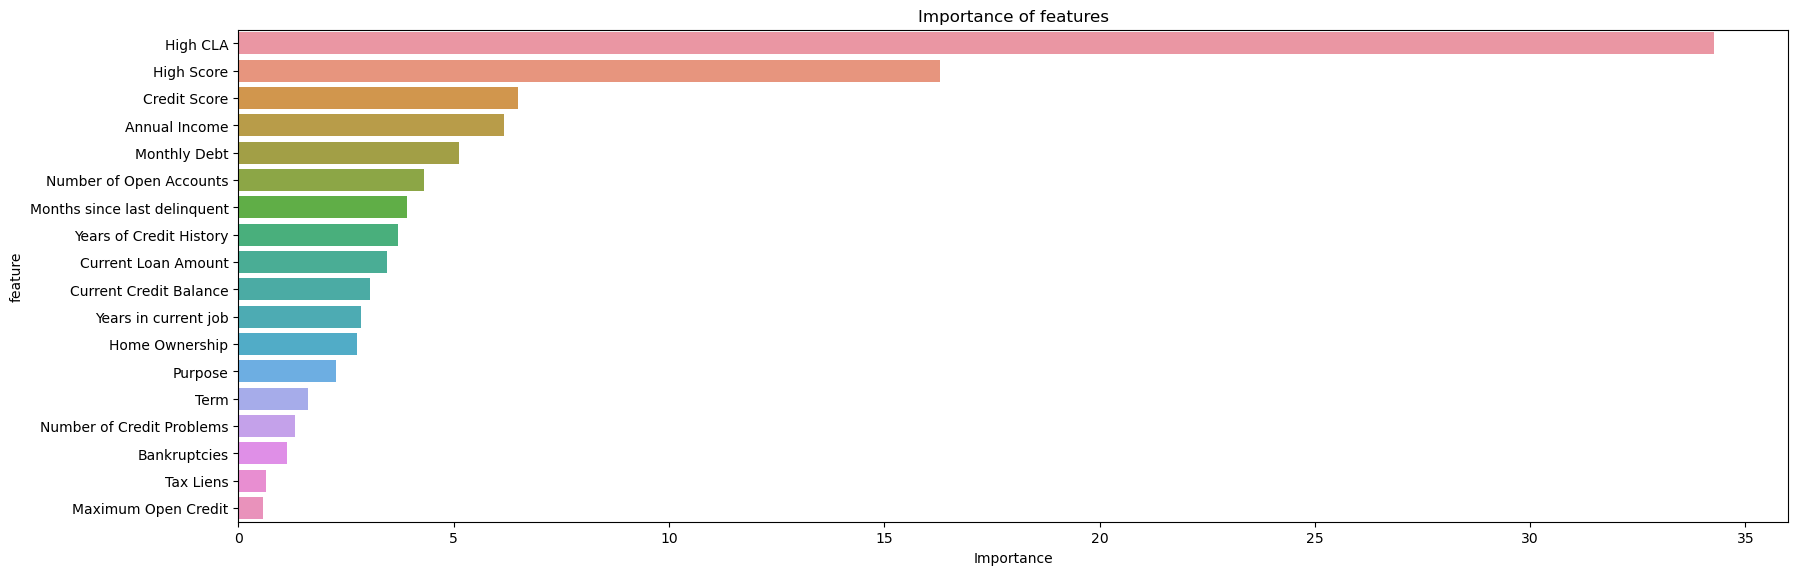

In [53]:
important_features_top = show_feature_importances(X_train.columns, 
                                                  model.feature_importances_)

### Классификация тестовых данных

In [54]:
test = pd.read_csv("./CW/course_project_test.csv")
test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [55]:
test = prepare_data(test)
test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,High CLA,High Score
0,2,7.901204e+05,4,0,9,12,220968,0,70,0,0,0,162470.0,105906.0,6813.0,726.372802,0,0
1,2,2.318380e+05,1,0,6,32,55946,0,8,0,8,0,78298.0,46037.0,2318.0,699.000000,0,0
2,1,1.152540e+06,3,0,10,13,204600,0,33,0,0,0,200178.0,146490.0,18729.0,726.000000,0,1
3,1,1.220313e+06,10,0,16,17,456302,0,70,0,0,0,217382.0,213199.0,27559.0,739.000000,0,0
4,1,2.340952e+06,6,0,11,23,1207272,0,32,0,0,1,777634.0,425391.0,42605.0,706.000000,0,0


In [58]:
y_test_pred = pd.DataFrame(model.predict(test))

In [62]:
y_test_pred.to_csv('./V_A_Ukolov_predictions.csv', index=False, header=False)

In [63]:
y_test_pred

,0
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,0
2497,0
2498,0
